Processing object 1 for json1:
  Encode ID: 1
  Type: campaign
  Name: APT BPP
  Node or Edge: node
  File: json1
Processing object 2 for json1:
  Encode ID: 2
  Type: intrusion-set
  Name: APT BPP
  Node or Edge: node
  File: json1
Processing object 3 for json1:
  Encode ID: 3
  Type: identity
  Name: Franistan
  Node or Edge: node
  File: json1
Processing object 4 for json1:
  Encode ID: 4
  Type: identity
  Name: Branistan People’s Party
  Node or Edge: node
  File: json1
Processing object 5 for json1:
  Encode ID: 5
  Type: identity
  Name: Branistan
  Node or Edge: node
  File: json1
Processing object 6 for json1:
  Encode ID: 6
  Type: attack-pattern
  Name: False Information Insertion
  Node or Edge: node
  File: json1
Processing object 7 for json1:
  Encode ID: 7
  Type: attack-pattern
  Name: DDoS Campaign
  Node or Edge: node
  File: json1
Processing object 8 for json1:
  Encode ID: 8
  Type: malware
  Name: DDoS Malware
  Node or Edge: node
  File: json1
Processing object 9 

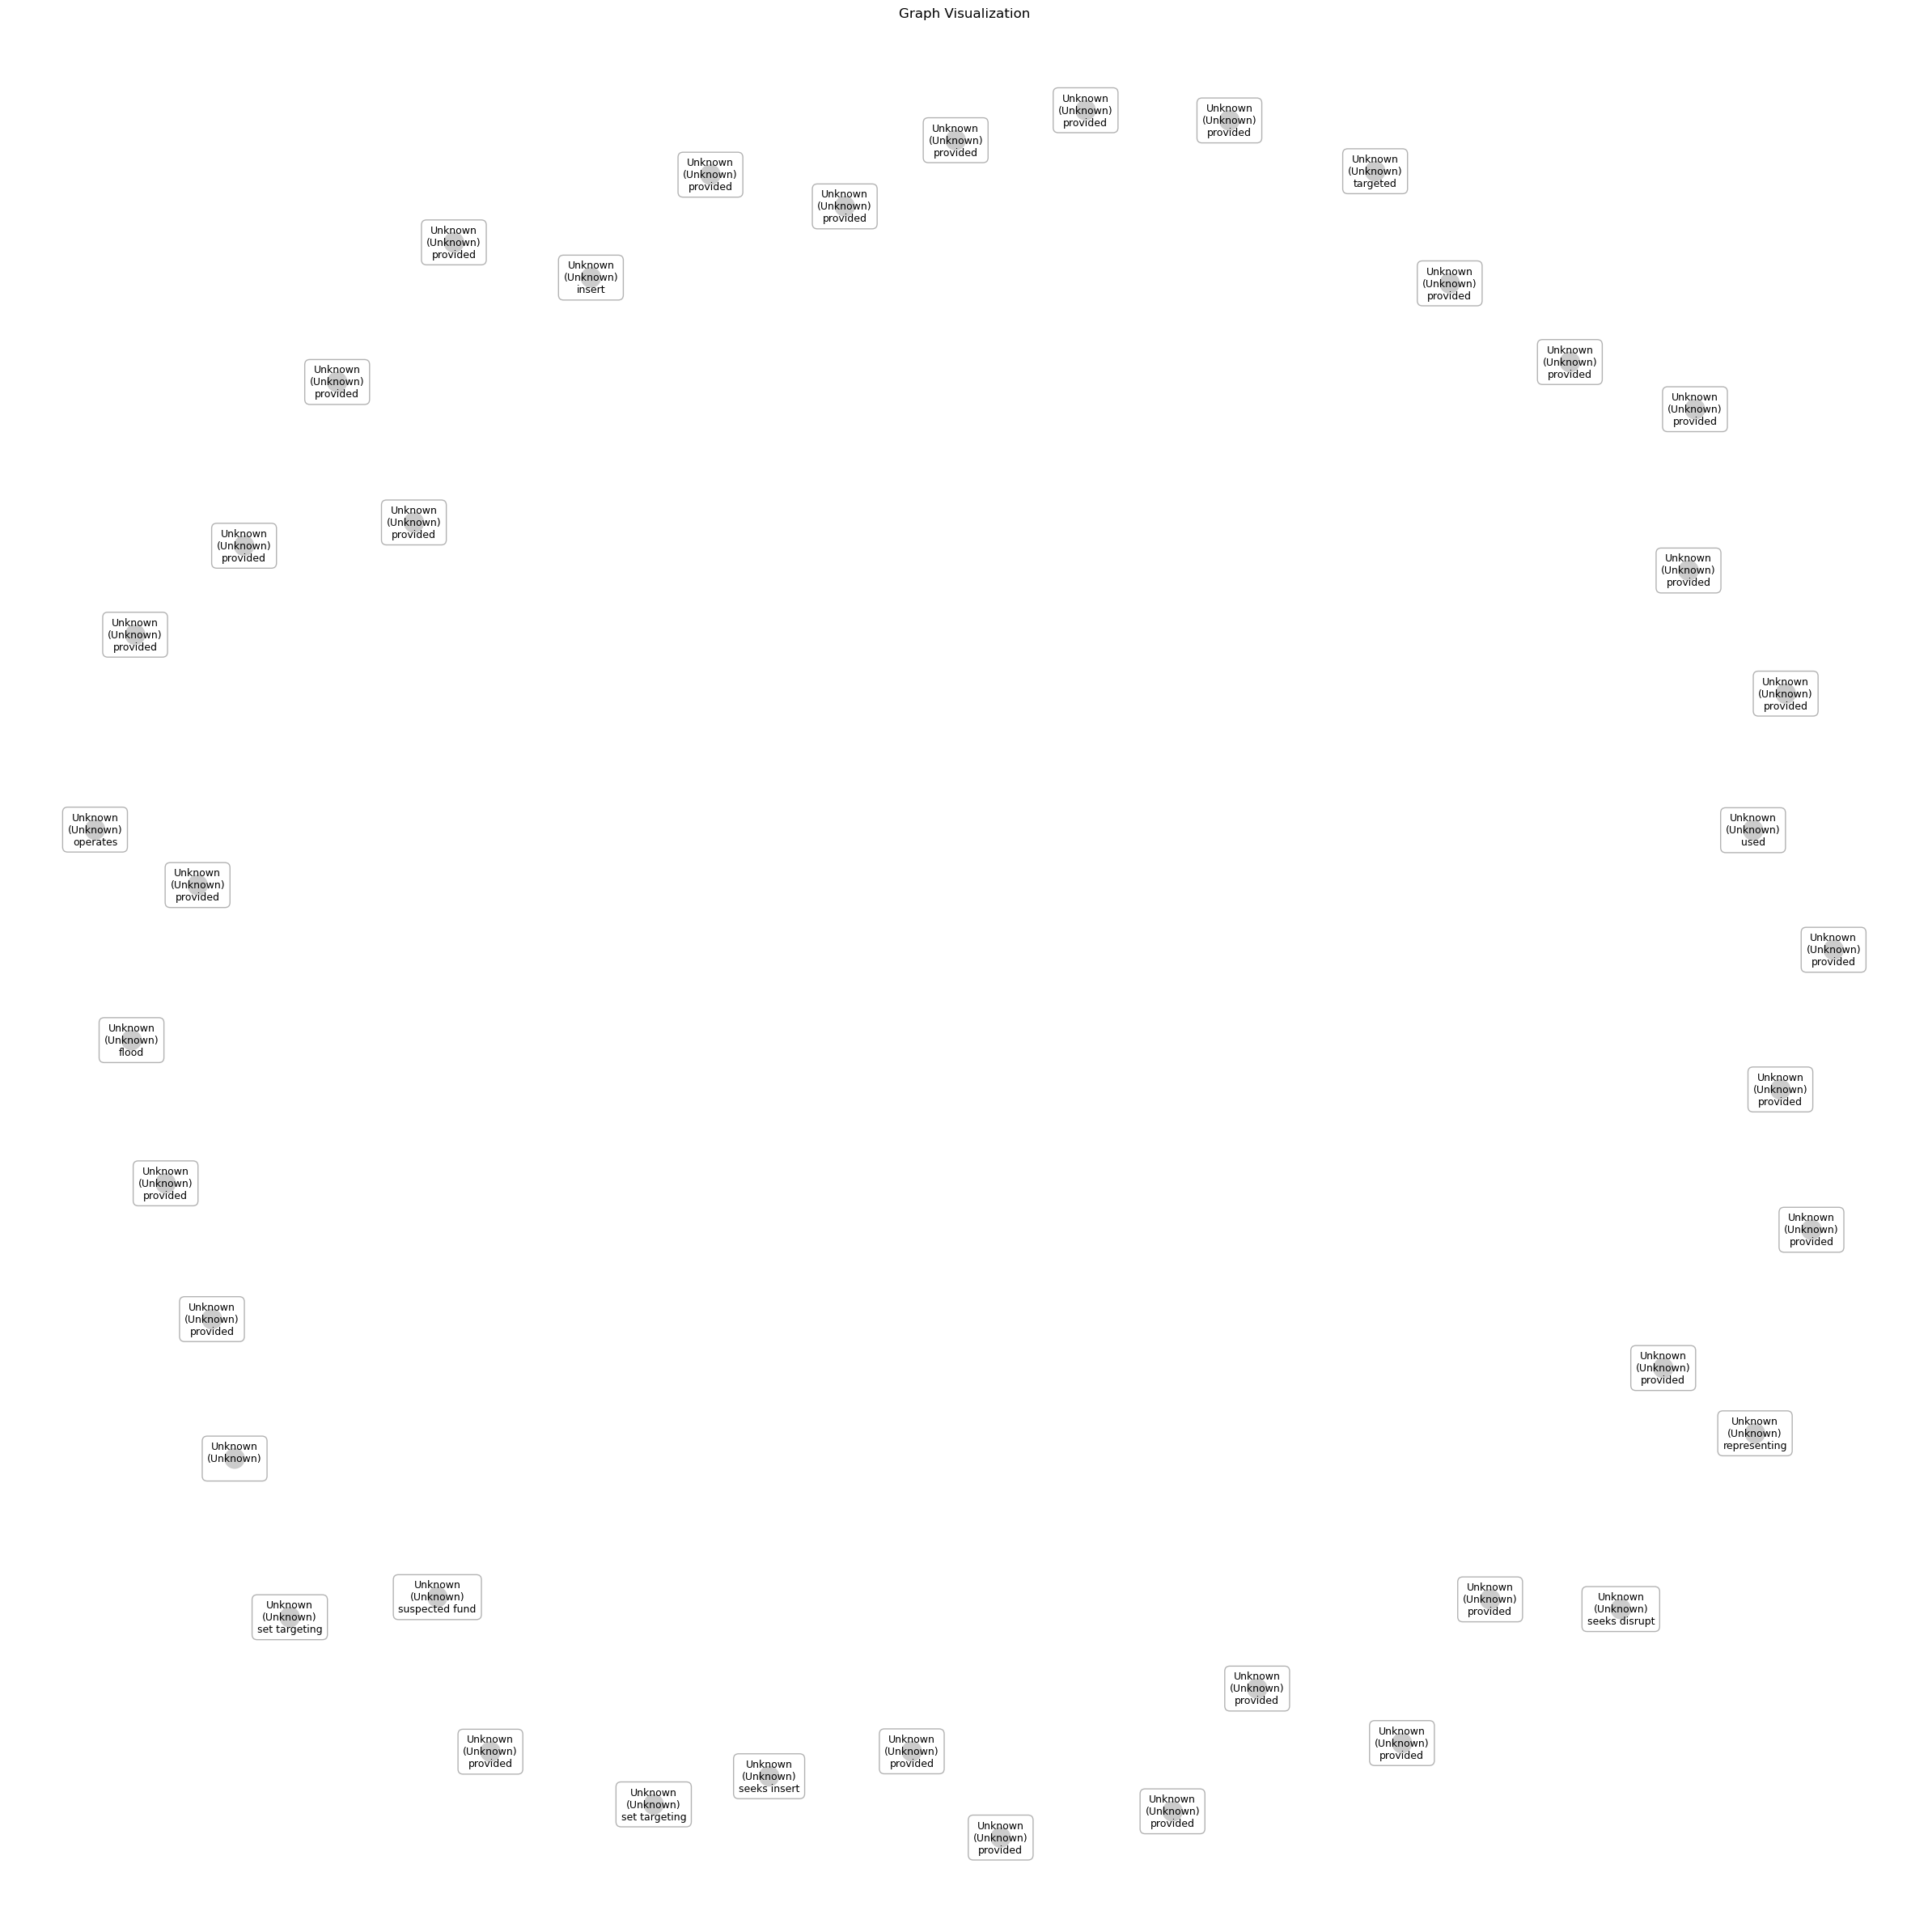

In [3]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import string
import pandas as pd
import spacy
import os
import heapq
from collections import defaultdict

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Create a new directory to save all files
output_dir = 'output_files'
os.makedirs(output_dir, exist_ok=True)

# Define global threshold variable
threshold = 0.8

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '.')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '.')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

def preprocess_text(text):
    """Preprocess text by lowercasing and removing punctuation."""
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return text

def get_embeddings(text):
    """Get BERT embeddings for the given text."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

def save_tokenized_texts_combined(tokenized_texts, file_label):
    """Save combined tokenized texts to a file."""
    with open(os.path.join(output_dir, f"combined_tokenized_output_{file_label}.txt"), "w") as f:
        for tokenized_text in tokenized_texts:
            f.write(" ".join(tokenized_text) + "\n")

def save_embeddings_combined(embeddings, file_label):
    """Save combined embeddings as .npy file."""
    combined_embeddings = np.vstack(embeddings)
    np.save(os.path.join(output_dir, f"combined_embeddings_{file_label}.npy"), combined_embeddings)

def json_to_text(data, file_label):
    texts = []
    embeddings = []
    tokenized_texts = []
    json_objects = {}
    original_ids = {}
    object_order = []
    for i, entry in enumerate(data):
        flattened_entry = flatten_json(entry)
        original_id = flattened_entry.pop('id', None)
        if original_id:
            original_ids[original_id] = flattened_entry

        flattened_entry['file'] = file_label
        flattened_entry['node_or_edge'] = 'edge' if 'source_ref' in flattened_entry and 'target_ref' in flattened_entry else 'node'
        
        text = ". ".join(f"{key}: {value}" for key, value in flattened_entry.items())
        text = preprocess_text(text)
        texts.append(text)

        tokenized_text = tokenizer.tokenize(text)
        tokenized_texts.append(tokenized_text)

        embedding = get_embeddings(text)
        embeddings.append(embedding)
        
        encode_id = flattened_entry.get('encodeID', i+1)
        json_objects[encode_id] = flattened_entry
        object_order.append(encode_id)
        
        print(f"Processing object {i+1} for {file_label}:")
        print(f"  Encode ID: {encode_id}")
        print(f"  Type: {flattened_entry.get('type', 'No type')}")
        print(f"  Name: {flattened_entry.get('name', 'No name')}")
        print(f"  Node or Edge: {flattened_entry['node_or_edge']}")
        print(f"  File: {flattened_entry['file']}")
    
    print(f"Number of objects in {file_label}: {len(json_objects)}")
    print(f"Number of embeddings in {file_label}: {len(embeddings)}")
    print(f"Object order in {file_label}: {object_order}")
    
    return texts, embeddings, tokenized_texts, json_objects, original_ids, object_order


def load_json(file_path):
    """Load JSON data from a file with detailed error handling."""
    try:
        with open(file_path, 'r') as file:
            data = file.read()
            return json.loads(data)
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from file - {file_path}")
        print(f"Error details: {e}")
        print(f"Faulty JSON content:\n{data}")
        return None


def assign_encode_ids(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, 
                      original_ids1, original_ids2, threshold, order1, order2):
    print("Contents of json_objects1:")
    for k, v in json_objects1.items():
        print(f"  {k}: {v.get('type', 'No type')} - {v.get('name', 'No name')} - {v.get('file', 'No file')}")
    
    print("Contents of json_objects2:")
    for k, v in json_objects2.items():
        print(f"  {k}: {v.get('type', 'No type')} - {v.get('name', 'No name')} - {v.get('file', 'No file')}")

    combined_texts = texts1 + texts2
    combined_embeddings = np.vstack(embeddings1 + embeddings2)
    
    combined_json_objects = {}
    for i, (k, v) in enumerate(json_objects1.items(), start=1):
        combined_json_objects[f"json1_{k}"] = v.copy()
        combined_json_objects[f"json1_{k}"]["original_number"] = i
    for i, (k, v) in enumerate(json_objects2.items(), start=1):
        combined_json_objects[f"json2_{k}"] = v.copy()
        combined_json_objects[f"json2_{k}"]["original_number"] = i
    
    combined_order = order1 + order2

    print("File attributes before processing:")
    for k, v in combined_json_objects.items():
        print(f"  {k}: {v.get('file', 'No file attribute')}")

    similarity_matrix = cosine_similarity(combined_embeddings)
    num_texts = len(combined_texts)
    comparison_matrix = np.zeros((num_texts, num_texts))

    # Priority queue to store similarities
    similarity_queue = []
    
    # Calculate similarities and add to priority queue
    for i, (key_i, obj_i) in enumerate(combined_json_objects.items()):
        for j, (key_j, obj_j) in enumerate(combined_json_objects.items()):
            if i < len(texts1) and j >= len(texts1):  # Only compare objects from different files
                similarity = similarity_matrix[i, j - len(texts1)]
                comparison_matrix[i, j - len(texts1)] = similarity
                if similarity > threshold and obj_i['file'] != obj_j['file']:
                    heapq.heappush(similarity_queue, (-similarity, key_i, key_j))  # Use negative similarity for max-heap

    encode_id = 1
    unmatched_encode_id = 10000
    encode_id_mapping = {}
    assigned_objects = set()

    # Process similarities in descending order
    while similarity_queue:
        similarity, key_i, key_j = heapq.heappop(similarity_queue)
        similarity = -similarity  # Convert back to positive
        
        if key_i not in assigned_objects and key_j not in assigned_objects:
            encode_id_mapping[key_i] = encode_id
            encode_id_mapping[key_j] = encode_id
            assigned_objects.add(key_i)
            assigned_objects.add(key_j)
            encode_id += 1

    # Assign unmatched IDs
    for key in combined_json_objects.keys():
        if key not in encode_id_mapping:
            encode_id_mapping[key] = unmatched_encode_id
            unmatched_encode_id += 1

    # Update objects with new encode IDs
    for key, obj in combined_json_objects.items():
        obj['encodeID'] = encode_id_mapping[key]
        if 'node_or_edge' not in obj:
            obj['node_or_edge'] = 'edge' if 'source_ref' in obj and 'target_ref' in obj else 'node'

    # Create a dictionary to map original IDs to encodeIDs
    id_to_encodeID = {original_id: obj['encodeID'] for original_id, obj in original_ids1.items() if 'encodeID' in obj}
    id_to_encodeID.update({original_id: obj['encodeID'] for original_id, obj in original_ids2.items() if 'encodeID' in obj})

    # Update source_ref and target_ref in relationship objects
    for obj in combined_json_objects.values():
        if obj['node_or_edge'] == 'edge':
            obj['source_ref'] = id_to_encodeID.get(obj['source_ref'], obj['source_ref'])
            obj['target_ref'] = id_to_encodeID.get(obj['target_ref'], obj['target_ref'])

    # Separate objects back into json_objects1 and json_objects2
    json_objects1 = {k.split('_')[1]: v for k, v in combined_json_objects.items() if k.startswith('json1_')}
    json_objects2 = {k.split('_')[1]: v for k, v in combined_json_objects.items() if k.startswith('json2_')}

    print("File attributes after processing:")
    for k, v in combined_json_objects.items():
        print(f"  {k}: {v.get('file', 'No file attribute')} - Original Number: {v.get('original_number')} - Encode ID: {v.get('encodeID')}")

    return json_objects1, json_objects2, comparison_matrix, combined_embeddings

# Example call to the function (for testing purposes, you should replace with actual data)
# assign_encode_ids(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, original_ids1, original_ids2, threshold, order1, order2)


def identify_node_or_edge_and_add_key(json_objects):
    """Identify if an object is a node or an edge based on the presence of two values matching encodeIDs of other objects,
    and add a new key-value pair indicating its type."""
    
    encode_ids = set()
    for entry in json_objects.values():
        if 'encodeID' in entry:
            encode_ids.add(entry['encodeID'])
        else:
            print(f"Warning: 'encodeID' missing from object: {entry}")
    
    for obj in json_objects.values():
        if 'encodeID' not in obj:
            obj['encodeID'] = max(encode_ids) + 1 if encode_ids else 1
            encode_ids.add(obj['encodeID'])
        
        # Remove the 'original_number' key if it exists
        obj.pop('original_number', None)
        
        values = set(obj.values())
        if len(values.intersection(encode_ids)) >= 2:
            obj['node_or_edge'] = "edge"
        else:
            obj['node_or_edge'] = "node"
    
    return json_objects

def save_json(data, file_path):
    """Save JSON data to a file."""
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

def build_graph(json_objects, suffix, color):
    """Build a graph based on JSON objects."""
    G = nx.Graph()
    valid_nodes = set()

    # Add nodes, ensuring unique IDs
    for key, obj in json_objects.items():
        if obj['node_or_edge'] != 'edge':  # Only add entities as nodes
            if obj.get('name') != 'Unknown Name':  # Avoid adding unknown name nodes
                unique_id = str(obj.get('encodeID')) + suffix
                node_name = f"{obj.get('encodeID')} ({obj['file']})"
                G.add_node(unique_id, description=obj.get('description', 'No description provided'))
                valid_nodes.add(unique_id)
        else:
            continue

    # Add edges, using unique IDs
    unique_edges = set()
    for obj in json_objects.values():
        if obj['node_or_edge'] == 'edge':
            source = str(obj.get('source_ref')) + suffix
            target = str(obj.get('target_ref')) + suffix
            edge = (source, target)
            if source in valid_nodes and target in valid_nodes and source != target:  # Ensure both nodes are valid and not the same
                G.add_edge(source, target)
                unique_edges.add(edge)
    return G


def visualize_graph(G):
    """Visualize a networkx graph with enhanced label formatting for readability."""
    num_nodes = len(G.nodes)
    figsize = get_optimal_figsize(num_nodes)
    k = get_optimal_k(num_nodes)

    plt.figure(figsize=figsize)  # Dynamically set figure size
    pos = nx.spring_layout(G, k=k)  # Dynamically set layout parameter

    # Draw nodes with their corresponding colors
    node_colors = [data.get('color', 'grey') for node, data in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)

    # Draw edges with specified styles and colors
    for (u, v, data) in G.edges(data=True):
        edge_style = data.get('style', 'dotted')
        edge_color = data.get('color', 'black')
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            style=edge_style,
            edge_color=edge_color,
            width=2
        )

    # Draw edge labels
    edge_labels = {(u, v): data.get('label', 'similar-to') for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Draw labels for nodes
    labels = {}
    for node, data in G.nodes(data=True):
        label = f"{data.get('label', 'Unknown')}\n({data.get('type', 'Unknown')})"
        description = data.get('description', 'No description provided')
        if description:
            doc = nlp(description)
            verbs = [token.text for token in doc if token.pos_ == 'VERB']
            label += f"\n{' '.join(verbs[:2])}"
        labels[node] = label

    for node, label in labels.items():
        x, y = pos[node]
        plt.text(x, y, label, fontsize=9, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='gray', alpha=0.6))

    plt.title('Graph Visualization')
    plt.axis('off')
    plt.show()

def get_optimal_figsize(num_nodes):
    """Determine an optimal figure size based on the number of nodes."""
    base_size = 10  # Base size for the figure
    scale_factor = 0.5  # Scale factor to adjust size
    return (base_size + num_nodes * scale_factor, base_size + num_nodes * scale_factor)

def get_optimal_k(num_nodes):
    """Determine an optimal k value for spring_layout based on the number of nodes."""
    base_k = 0.5  # Base k value
    scale_factor = 0.1  # Scale factor to adjust k
    return base_k + num_nodes * scale_factor

# Define node substitution cost function
def node_subst_cost(n1, n2):
    """Define cost for node substitution."""
    return 0 if n1 == n2 else 1

# Define edge substitution cost function
def edge_subst_cost(e1, e2):
    """Define cost for edge substitution."""
    return 0 if e1 == e2 else 1

def calculate_distances(json_objects1, json_objects2):
    """Calculate node distance, key distance, value distance, and graph distance."""
    def jaccard_distance(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return 1 - intersection / union if union != 0 else 1

    def set_distance(set1, set2):
        return abs(len(set1) - len(set2))

    # Node distance
    nodes1 = set(json_objects1.keys())
    nodes2 = set(json_objects2.keys())
    node_distance = set_distance(nodes1, nodes2)
    node_jaccard = jaccard_distance(nodes1, nodes2)

    # Key distance
    keys1 = set(k for obj in json_objects1.values() for k in obj.keys())
    keys2 = set(k for obj in json_objects2.values() for k in obj.keys())
    key_distance = set_distance(keys1, keys2)
    key_jaccard = jaccard_distance(keys1, keys2)

    # Value distance
    values1 = set(v for obj in json_objects1.values() for v in obj.values() if isinstance(v, str))
    values2 = set(v for obj in json_objects2.values() for v in obj.values() if isinstance(v, str))
    value_distance = set_distance(values1, values2)
    value_jaccard = jaccard_distance(values1, values2)

    # Graph distance (using node and edge comparison)
    G1 = build_graph(json_objects1, '_blue', 'blue')
    G2 = build_graph(json_objects2, '_red', 'red')
    graph_distance = nx.graph_edit_distance(G1, G2, node_subst_cost=node_subst_cost, edge_subst_cost=edge_subst_cost)

    print(f"Node Distance (Simple): {node_distance}")
    print(f"Node Distance (Jaccard): {node_jaccard:.2f}")
    print(f"Key Distance (Simple): {key_distance}")
    print(f"Key Distance (Jaccard): {key_jaccard:.2f}")
    print(f"Value Distance (Simple): {value_distance}")
    print(f"Value Distance (Jaccard): {value_jaccard:.2f}")
    print(f"Graph Distance: {graph_distance:.2f}")

def create_comparison_matrix(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, threshold):
    combined_embeddings = np.vstack(embeddings1 + embeddings2)
    similarity_matrix = cosine_similarity(combined_embeddings)

    num_texts1 = len(texts1)
    num_texts2 = len(texts2)
    comparison_data = []

    for i in range(num_texts1):
        row = []
        for j in range(num_texts2):
            similarity = similarity_matrix[i, num_texts1 + j]
            match = 1 if similarity > threshold else 0
            row.append(match)
        comparison_data.append(row)

    # Use only encodeID for labels
    labels1 = [f"{obj['encodeID']}" for obj in json_objects1.values()]
    labels2 = [f"{obj['encodeID']}" for obj in json_objects2.values()]

    comparison_df = pd.DataFrame(comparison_data, index=labels1, columns=labels2)

    return comparison_df, similarity_matrix


def save_comparison_matrix_to_excel(comparison_df, similarity_matrix, file_path, labels1, labels2):
    with pd.ExcelWriter(os.path.join(output_dir, file_path)) as writer:
        comparison_df.to_excel(writer, sheet_name='Comparison Matrix')

        similarity_submatrix = similarity_matrix[:len(labels1), len(labels1):len(labels1)+len(labels2)]
        similarity_df = pd.DataFrame(similarity_submatrix, index=labels1, columns=labels2)
        similarity_df.to_excel(writer, sheet_name='Similarity Values')

def save_embeddings_to_excel(embeddings1, embeddings2, json_objects1, json_objects2, file_path, threshold):
    aggregated_embeddings1 = np.array([embedding.mean(axis=0) for embedding in embeddings1])
    aggregated_embeddings2 = np.array([embedding.mean(axis=0) for embedding in embeddings2])
    
    similarity_matrix = cosine_similarity(aggregated_embeddings1, aggregated_embeddings2)
    
    # Use only encodeID for labels
    labels1 = [f"{obj['encodeID']}" for obj in json_objects1.values()]
    labels2 = [f"{obj['encodeID']}" for obj in json_objects2.values()]
    
    similarity_df = pd.DataFrame(similarity_matrix, index=labels1, columns=labels2)
    
    match_matrix = (similarity_matrix > threshold).astype(int)
    match_df = pd.DataFrame(match_matrix, index=labels1, columns=labels2)
    
    with pd.ExcelWriter(os.path.join(output_dir, file_path)) as writer:
        similarity_df.to_excel(writer, sheet_name='Similarity Matrix')
        match_df.to_excel(writer, sheet_name='Match Matrix')

def save_jaccard_distances_to_excel(similarity_matrix, json_objects1, json_objects2, file_path, G1, G2):
    num_texts1 = len(json_objects1)
    num_texts2 = len(json_objects2)
    jaccard_distances = []

    similarity_submatrix = similarity_matrix[:num_texts1, :num_texts2]

    if similarity_submatrix.shape != (num_texts1, num_texts2):
        raise ValueError(f"Expected submatrix shape ({num_texts1}, {num_texts2}), but got {similarity_submatrix.shape}")

    print(f"Keys in json_objects1: {list(json_objects1.keys())}")
    print(f"Keys in json_objects2: {list(json_objects2.keys())}")

    keys1 = list(json_objects1.keys())
    keys2 = list(json_objects2.keys())

    for i, key1 in enumerate(keys1):
        for j, key2 in enumerate(keys2):
            intersection = similarity_submatrix[i, j]
            union = 1
            jaccard_distance = 1 - intersection / union if union != 0 else 1

            obj1 = json_objects1[key1]
            obj2 = json_objects2[key2]

            type1 = obj1.get('node_or_edge', 'unknown')
            type2 = obj2.get('node_or_edge', 'unknown')

            jaccard_distances.append({
                'Text 1 Index': i,
                'Text 2 Index': j,
                'Text 1 Label': f"{obj1['encodeID']}",
                'Text 2 Label': f"{obj2['encodeID']}",
                'Type 1': type1,
                'Type 2': type2,
                'Intersection (Cosine Similarity)': intersection,
                'Union': union,
                'Jaccard Distance': jaccard_distance
            })

    jaccard_df = pd.DataFrame(jaccard_distances)

    node_summary = jaccard_summary(
        set(obj['encodeID'] for obj in json_objects1.values()),
        set(obj['encodeID'] for obj in json_objects2.values()),
        'Node Distance'
    )

    key_summary = jaccard_summary(
        set(k for obj in json_objects1.values() for k in obj.keys()),
        set(k for obj in json_objects2.values() for k in obj.keys()),
        'Key Distance'
    )

    value_summary = jaccard_summary(
        set(v for obj in json_objects1.values() for v in obj.values() if isinstance(v, str)),
        set(v for obj in json_objects2.values() for v in obj.values() if isinstance(v, str)),
        'Value Distance'
    )

    graph_summary = jaccard_summary(
        set(G1.edges()),
        set(G2.edges()),
        'Graph Distance'
    )

    summary_df = pd.DataFrame([node_summary, key_summary, value_summary, graph_summary])

    labels1 = [f"{obj['encodeID']}" for obj in json_objects1.values()]
    labels2 = [f"{obj['encodeID']}" for obj in json_objects2.values()]

    cosine_df = pd.DataFrame(similarity_submatrix, index=labels1, columns=labels2)

    nodes_details = []
    edges_details = []

    for i, key1 in enumerate(keys1):
        for j, key2 in enumerate(keys2):
            type1 = json_objects1[key1]['node_or_edge']
            type2 = json_objects2[key2]['node_or_edge']
            if type1 == 'node' and type2 == 'node':
                nodes_details.append({
                    'Text 1 Index': i,
                    'Text 2 Index': j,
                    'Text 1 Label': labels1[i],
                    'Text 2 Label': labels2[j],
                    'Cosine Similarity': similarity_submatrix[i, j]
                })
            elif type1 == 'edge' and type2 == 'edge':
                edges_details.append({
                    'Text 1 Index': i,
                    'Text 2 Index': j,
                    'Text 1 Label': labels1[i],
                    'Text 2 Label': labels2[j],
                    'Cosine Similarity': similarity_submatrix[i, j]
                })

    nodes_df = pd.DataFrame(nodes_details)
    edges_df = pd.DataFrame(edges_details)

    with pd.ExcelWriter(file_path) as writer:
        cosine_df.to_excel(writer, sheet_name='Cosine Similarity')
        nodes_df.to_excel(writer, sheet_name='Nodes Details', index=False)
        edges_df.to_excel(writer, sheet_name='Edges Details', index=False)
        jaccard_df.to_excel(writer, sheet_name='Jaccard Distances', index=False)
        summary_df.to_excel(writer, sheet_name='Summary', index=False)

    print(f"Jaccard distances saved to '{file_path}'.")

def jaccard_summary(set1, set2, label):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_distance = 1 - intersection / union if union != 0 else 1
    return {
        'Metric': f'{label} (Jaccard)',
        'Distance': jaccard_distance,
        'Intersection': intersection,
        'Union': union
    }

def calculate_detailed_distances(json_objects1, json_objects2, threshold):
    node_i, node_d, node_s = 0, 0, 0
    edge_i, edge_d, edge_s = 0, 0, 0
    key_i, key_d, key_s = 0, 0, 0
    value_i, value_d, value_s = 0, 0, 0

    # Identify nodes and edges
    nodes1 = {k: v for k, v in json_objects1.items() if v['node_or_edge'] == 'node'}
    nodes2 = {k: v for k, v in json_objects2.items() if v['node_or_edge'] == 'node'}
    edges1 = {k: v for k, v in json_objects1.items() if v['node_or_edge'] == 'edge'}
    edges2 = {k: v for k, v in json_objects2.items() if v['node_or_edge'] == 'edge'}

    # Debug: Print the nodes and edges
    print("Nodes in JSON1:", list(nodes1.keys()))
    print("Nodes in JSON2:", list(nodes2.keys()))
    print("Edges in JSON1:", list(edges1.keys()))
    print("Edges in JSON2:", list(edges2.keys()))

    # Compare nodes
    nodes_only_in_1 = set(nodes1.keys()) - set(nodes2.keys())
    nodes_only_in_2 = set(nodes2.keys()) - set(nodes1.keys())
    node_s = min(len(nodes_only_in_1), len(nodes_only_in_2))
    node_d = len(nodes_only_in_1) - node_s
    node_i = len(nodes_only_in_2) - node_s

    print(f"Node substitutions: {node_s}")
    print(f"Node deletions: {node_d}")
    print(f"Node insertions: {node_i}")

    # Compare edges based on their content, not just IDs
    edges1_set = {(e['source_ref'], e['target_ref']) for e in edges1.values()}
    edges2_set = {(e['source_ref'], e['target_ref']) for e in edges2.values()}
    
    edges_only_in_1 = edges1_set - edges2_set
    edges_only_in_2 = edges2_set - edges1_set
    
    edge_d = len(edges_only_in_1)
    edge_i = len(edges_only_in_2)
    edge_s = 0  # There are no substitutions for edges, only insertions and deletions

    print(f"Edge substitutions: {edge_s}")
    print(f"Edge deletions: {edge_d}")
    print(f"Edge insertions: {edge_i}")

    # Compare keys and values for nodes present in both JSONs
    for node_id in set(nodes1.keys()) & set(nodes2.keys()):
        obj1, obj2 = nodes1[node_id], nodes2[node_id]
        keys1, keys2 = set(obj1.keys()) - {'file'}, set(obj2.keys()) - {'file'}
        
        keys_only_in_1 = keys1 - keys2
        keys_only_in_2 = keys2 - keys1
        key_s += min(len(keys_only_in_1), len(keys_only_in_2))
        key_d += len(keys_only_in_1) - key_s
        key_i += len(keys_only_in_2) - key_s

        for key in keys1 & keys2:
            if key != 'file' and obj1[key] != obj2[key]:
                value_s += 1

    print(f"Key substitutions: {key_s}")
    print(f"Key deletions: {key_d}")
    print(f"Key insertions: {key_i}")
    print(f"Value substitutions: {value_s}")

    # Calculate distances
    node_distance = node_i + node_d + node_s
    edge_distance = edge_i + edge_d + edge_s
    key_distance = key_i + key_d + key_s
    value_distance = value_s  # value_i and value_d are not used in this logic

    detailed_distance = [{
        "node_distance": node_distance,
        "node_i": node_i,
        "node_d": node_d,
        "node_s": node_s,
        "edge_distance": edge_distance,
        "edge_i": edge_i,
        "edge_d": edge_d,
        "edge_s": edge_s,
        "key_distance": key_distance,
        "key_i": key_i,
        "key_d": key_d,
        "key_s": key_s,
        "value_distance": value_distance,
        "value_i": 0,
        "value_d": 0,
        "value_s": value_s
    }]

    return detailed_distance

def calculate_graph_edit_distance(G1, G2):
    def node_subst_cost(n1, n2):
        return 0 if n1 == n2 else 1

    def node_del_cost(n):
        return 1

    def node_ins_cost(n):
        return 1

    def edge_subst_cost(e1, e2):
        return 0 if e1 == e2 else 1

    def edge_del_cost(e):
        return 1

    def edge_ins_cost(e):
        return 1

    ged = nx.graph_edit_distance(
        G1, G2,
        node_subst_cost=node_subst_cost,
        node_del_cost=node_del_cost,
        node_ins_cost=node_ins_cost,
        edge_subst_cost=edge_subst_cost,
        edge_del_cost=edge_del_cost,
        edge_ins_cost=edge_ins_cost
    )

    return ged

def output_networkx_style(G1, G2):
    def node_match(n1, n2):
        # Consider nodes similar if they have the same type and name
        return n1.get('type') == n2.get('type') and n1.get('name') == n2.get('name')

    def edge_match(e1, e2):
        # Consider edges similar if they have the same relationship_type
        return e1.get('relationship_type') == e2.get('relationship_type')

    def node_subst_cost(n1, n2):
        return 0.5 if node_match(n1, n2) else 1

    def node_del_cost(n):
        return 1

    def node_ins_cost(n):
        return 1

    def edge_subst_cost(e1, e2):
        return 0.5 if edge_match(e1, e2) else 1

    def edge_del_cost(e):
        return 1

    def edge_ins_cost(e):
        return 1

    ged = nx.graph_edit_distance(
        G1, G2,
        node_match=node_match,
        edge_match=edge_match,
        node_subst_cost=node_subst_cost,
        node_del_cost=node_del_cost,
        node_ins_cost=node_ins_cost,
        edge_subst_cost=edge_subst_cost,
        edge_del_cost=edge_del_cost,
        edge_ins_cost=edge_ins_cost
    )
    
    inserted_nodes = set(G2.nodes()) - set(G1.nodes())
    deleted_nodes = set(G1.nodes()) - set(G2.nodes())
    substituted_nodes = {(n1, n2) for n1 in G1.nodes() for n2 in G2.nodes() if node_match(G1.nodes[n1], G2.nodes[n2])}
    
    inserted_edges = set(G2.edges()) - set(G1.edges())
    deleted_edges = set(G1.edges()) - set(G2.edges())
    substituted_edges = {(e1, e2) for e1 in G1.edges() for e2 in G2.edges() if edge_match(G1.edges[e1], G2.edges[e2])}
    
    node_insertion_cost = sum(node_ins_cost(G2.nodes[n]) for n in inserted_nodes)
    node_deletion_cost = sum(node_del_cost(G1.nodes[n]) for n in deleted_nodes)
    node_substitution_cost = sum(node_subst_cost(G1.nodes[n1], G2.nodes[n2]) for n1, n2 in substituted_nodes)
    
    edge_insertion_cost = sum(edge_ins_cost(G2.edges[e]) for e in inserted_edges)
    edge_deletion_cost = sum(edge_del_cost(G1.edges[e]) for e in deleted_edges)
    edge_substitution_cost = sum(edge_subst_cost(G1.edges[e1], G2.edges[e2]) for e1, e2 in substituted_edges)
    
    total_node_cost = node_insertion_cost + node_deletion_cost + node_substitution_cost
    total_edge_cost = edge_insertion_cost + edge_deletion_cost + edge_substitution_cost
    total_cost = total_node_cost + total_edge_cost

    output = f"Graph Edit Distance: {ged}\n"
    output += f"Inserted Nodes: {inserted_nodes}\n"
    output += f"Deleted Nodes: {deleted_nodes}\n"
    output += f"Substituted Nodes: {substituted_nodes}\n"
    output += f"Inserted Edges: {inserted_edges}\n"
    output += f"Deleted Edges: {deleted_edges}\n"
    output += f"Substituted Edges: {substituted_edges}\n"
    output += "Costs:\n"
    output += f"Node Insertion Cost: {node_insertion_cost}\n"
    output += f"Node Deletion Cost: {node_deletion_cost}\n"
    output += f"Node Substitution Cost: {node_substitution_cost}\n"
    output += f"Edge Insertion Cost: {edge_insertion_cost}\n"
    output += f"Edge Deletion Cost: {edge_deletion_cost}\n"
    output += f"Edge Substitution Cost: {edge_substitution_cost}\n"
    output += f"Total Node Cost: {total_node_cost}\n"
    output += f"Total Edge Cost: {total_edge_cost}\n"
    output += f"Total Cost: {total_cost}"

    with open(os.path.join(output_dir, 'networkx_style_output.txt'), 'w') as f:
        f.write(output)

    print("NetworkX style output saved to 'output_files/networkx_style_output.txt'.")

def main():
    global threshold
    # Get input from user
    path1 = input("Enter the file path for JSON 1: ").strip('"')
    path2 = input("Enter the file path for JSON 2: ").strip('"')
    threshold = float(input("Enter the similarity threshold (e.g., 0.95): ").strip())

    # Load JSON data
    data1 = load_json(path1)
    data2 = load_json(path2)
    if data1 is None or data2 is None:
        return

    # Process JSON data
    texts1, embeddings1, tokenized_texts1, json_objects1, original_ids1, order1 = json_to_text(data1, 'json1')
    texts2, embeddings2, tokenized_texts2, json_objects2, original_ids2, order2 = json_to_text(data2, 'json2')

    print(f"Number of objects before assign_encode_ids, json_objects1: {len(json_objects1)}, json_objects2: {len(json_objects2)}")

    # Assign encode IDs
    json_objects1, json_objects2, comparison_matrix, combined_embeddings = assign_encode_ids(
        texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2,
        original_ids1, original_ids2, threshold, order1, order2)

    if not json_objects1:
        print("Error: json_objects1 is empty after processing.")
        return

    # Identify nodes and edges
    json_objects1 = identify_node_or_edge_and_add_key(json_objects1)
    json_objects2 = identify_node_or_edge_and_add_key(json_objects2)

    # Save processed data
    combined_tokenized_texts = tokenized_texts1 + tokenized_texts2
    save_tokenized_texts_combined(combined_tokenized_texts, 'combined')
    save_embeddings_combined(embeddings1 + embeddings2, 'combined')

    save_embeddings_to_excel(embeddings1, embeddings2,
        json_objects1, json_objects2,
        'embeddings_and_similarity.xlsx', threshold)

    save_json(json_objects1, os.path.join(output_dir, 'normalized_data1.json'))
    save_json(json_objects2, os.path.join(output_dir, 'normalized_data2.json'))

    # Create and save comparison matrix
    comparison_df, similarity_matrix = create_comparison_matrix(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, threshold)
    save_comparison_matrix_to_excel(comparison_df, similarity_matrix, 'comparison_matrix.xlsx',
        [f"{obj['encodeID']}" for obj in json_objects1.values()],
        [f"{obj['encodeID']}" for obj in json_objects2.values()])

    print("Comparison matrix saved to 'output_files/comparison_matrix.xlsx'.")

    # Build graphs
    G1 = build_graph(json_objects1, '_blue', 'blue')
    G2 = build_graph(json_objects2, '_red', 'red')

    output_networkx_style(G1, G2)

    calculate_distances(json_objects1, json_objects2)

    # Save Jaccard distances
    sub_similarity_matrix = similarity_matrix[:len(json_objects1), len(json_objects1):len(json_objects1)+len(json_objects2)]
    save_jaccard_distances_to_excel(sub_similarity_matrix, 
        json_objects1, json_objects2, 
        os.path.join(output_dir, 'jaccard_distances.xlsx'), G1, G2)

    # Calculate and save detailed distances
    detailed_distances = calculate_detailed_distances(json_objects1, json_objects2, threshold)
    save_json(detailed_distances, os.path.join(output_dir, 'detailed_distances.json'))
    print("Detailed distances saved to 'output_files/detailed_distances.json'.")

    # Visualize graph
    visualize_graph(nx.compose(G1, G2))

if __name__ == "__main__":
    main()
